# Ciencia de datos aplicada (ITBA): Modelo de tercer entregable

**Entrenamiento y validación de Modelos de Machine Learning**

**Equipo:** Desiree Melisa Limachi, Felipe Mendiondo, German Lorenzani

**Nombre del proyecto**: Sistema de pricing dinámico para ATUA



### 🧾 1. Importación y carga de librerías


In [ ]:
import pandas as pd
import sys
print(sys.executable)
!pip install --upgrade pip
!{sys.executable} -m pip install lightgbm

# Reemplazá con la ruta local si se descargo el archivo manualmente, ubicar ambos archivos en una carpeta dataset
#df = pd.read_csv('https://github.com/dlimachi/TP-ATUA/blob/main/dataset/Reservas_transformado.csv')


c:\Users\desir\AppData\Local\Programs\Python\Python39\python.exe
  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/5e/23/f8b28ca248bb629b9e08f877dd2965d1994e1674a03d67cd10c5246da248/lightgbm-4.6.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------------------------- -------------- 0.9/1.5 MB 28.5 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 22.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from lightgbm import LGBMClassifier


## 🔧 Transformaciones


En esta etapa consolidamos el proceso completo de transformación del dataset limpio, generando todas las variables que servirán como entrada para el modelo predictivo y guardando el resultado final como Reservas_transformado.csv. Este archivo va a ser la base estructurada y enriquecida que concentra la lógica del negocio y los patrones de comportamiento detectados en las reservas reales.

Uno de los primeros pasos consiste en construir la variable Rango de precio, que clasifica cada reserva en “Bajo”, “Medio” o “Alto” en función del precio por día publicado. Definimos umbrales específicos que consideramos representativos del mercado actual. Esta categorización nos permite abordar el problema con un enfoque de clasificación supervisada, simplificando el análisis.

También calculamos la Antigüedad de la reserva, es decir, cuántos días antes del check-in fue realizada. A partir de ese valor generamos una clasificación en tres niveles: “Último momento”, “Moderada” y “Anticipada”. El objetivo de esta variable es capturar distintos tipos de comportamiento del usuario en función del nivel de planificación, lo cual puede relacionarse directamente con la estrategia de precios o disponibilidad.

Incorporamos además la variable Temporada, que clasifica cada reserva como “Alta” o “Baja” en función del mes del check-in. Consideramos como alta los meses de mayor demanda turística: diciembre, enero, febrero y julio. Esta dimensión temporal nos permite tener en cuenta el impacto de la estacionalidad en la demanda y en los precios.

A esto se suman dos variables horarias: Franja Check-in y Franja Creación, que dividen el día en bloques horarios —“Madrugada”, “Mañana”, “Tarde” y “Noche”— en función de la hora en que se creó la reserva o en la que inicia el alquiler. Estas franjas permiten estudiar la distribución temporal de las reservas y detectar posibles patrones de comportamiento horario que puedan ser relevantes para el negocio.

Finalmente, calculamos la Duración del alquiler como la diferencia en días entre el check-out y el check-in. Esta variable es clave tanto para evaluar la rentabilidad de una reserva como para alimentar futuros modelos que determinen el tiempo mínimo económicamente viable para ofrecer un vehículo. Se eliminan las reservas que no tienen fechas válidas y se filtran los datos para conservar únicamente aquellas cuyo estado es COMPLETADA, lo que garantiza que solo trabajamos con operaciones reales.


In [ ]:
import pandas as pd

df_filtered = pd.read_csv('dataset/Reservas_limpio.csv', sep=';')

# Crear la categoría de rango de precios por día
def clasificar_precio_dia(precio):
    if pd.isna(precio):
        return 'Desconocido'
    elif precio < 53000:
        return 'Bajo'
    elif precio <= 63000:
        return 'Medio'
    else:
        return 'Alto'

df_filtered['Rango de precio'] = df_filtered['Precio de la publicacion'].apply(clasificar_precio_dia)
df_filtered['Rango de precio'] = pd.Categorical(
    df_filtered['Rango de precio'],
    categories=['Bajo', 'Medio', 'Alto', 'Desconocido'],
    ordered=True
)

checkin_parsed = pd.to_datetime(df_filtered['Check-in'], errors='coerce', dayfirst=True)
creacion_parsed = pd.to_datetime(df_filtered['Fecha de creacion'], errors='coerce')

df_filtered['Antiguedad dias'] = (checkin_parsed - creacion_parsed).dt.days

# Clasificar en categorías
def clasificar_antiguedad(dias):
    if pd.isna(dias):
        return 'Desconocido'
    if dias <= 7:
        return 'Último momento'
    elif dias <= 14:
        return 'Moderada'
    else:
        return 'Anticipada'

df_filtered['Antigüedad de Reserva'] = df_filtered['Antiguedad dias'].apply(clasificar_antiguedad)


# ----------- Temporada (Alta o Baja) -----------

df_filtered['Check-in'] = pd.to_datetime(df_filtered['Check-in'], format='%d/%m/%y %H:%M', errors='coerce')
df_filtered['Check-out'] = pd.to_datetime(df_filtered['Check-out'], format='%d/%m/%y %H:%M', errors='coerce')
df_filtered['Fecha de creacion'] = pd.to_datetime(df_filtered['Fecha de creacion'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

def definir_temporada(fecha):
    if pd.isna(fecha):
        return 'Desconocida'
    mes = fecha.month
    if mes in [12, 1, 2, 7]:
        return 'Alta'
    return 'Baja'

df_filtered['Temporada'] = df_filtered['Check-in'].apply(definir_temporada)

# ----------- Franja horaria de demanda por Check-in -----------
def franja_horaria(fecha):
    if pd.isna(fecha):
        return 'Desconocida'
    hora = fecha.hour
    if 6 <= hora < 12:
        return 'Mañana'
    elif 12 <= hora < 18:
        return 'Tarde'
    elif 18 <= hora < 24:
        return 'Noche'
    else:
        return 'Madrugada'

df_filtered['Franja Check-in'] = df_filtered['Check-in'].apply(franja_horaria)

# ----------- Franja horaria de creación de reserva -----------
df_filtered['Franja Creación'] = df_filtered['Fecha de creacion'].apply(franja_horaria)


# Calcular duración en días
df_filtered['Duracion'] = (df_filtered['Check-out'] - df_filtered['Check-in']).dt.days
df_filtered = df_filtered.dropna(subset=['Check-in', 'Check-out'])

df_filtered = df_filtered[df_filtered['Estado'] == 'COMPLETADA']

df_filtered.to_csv('dataset/Reservas_transformado.csv', sep=';', index=False)


C:\Users\desir\AppData\Local\Temp\ipykernel_24740\3119651848.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  checkin_parsed = pd.to_datetime(df_filtered['Check-in'], errors='coerce', dayfirst=True)


## 🧾 Carga de datos y preparación

En esta etapa preparamos el conjunto de datos transformado para su uso en el modelo predictivo. Partimos del archivo Reservas_transformado.csv y seleccionamos aquellas que consideramos más relevantes para predecir el rango de precio de una reserva.

Definimos como variables predictoras (features) a Temporada, Provincia, Modelo, Marca y Duración. Estas variables tienen información sobre el contexto temporal, la ubicación, las características del vehículo y la extensión del alquiler, todos factores que creemos influyen en la determinación del precio. Aplicamos pd.get_dummies() sobre estas variables para convertirlas en variables numéricas mediante codificación one-hot, ya que los algoritmos como SVM no pueden trabajar con datos categóricos en formato texto.

Paso siguiente, definimos la variable objetivo (y) como el Rango de precio, que fue previamente categorizado en “Bajo”, “Medio” y “Alto”. Esta variable es el foco del modelo de clasificación, y será utilizada para entrenar un algoritmo que, a partir de las características de una reserva, pueda predecir de forma automática a qué rango de precios pertenece. Esta preparación del conjunto de datos es fundamental para asegurar que el modelo reciba entradas en un formato adecuado y alineado con la lógica del problema que buscamos resolver.

In [ ]:
df = pd.read_csv('dataset/Reservas_transformado.csv', sep=';')

# Variables predictoras
features = ['Temporada', 'Provincia', 'Modelo', 'Marca', 'Duracion']
X = pd.get_dummies(df[features])

# Variable target
y = df['Rango de precio']

Los separamos en entrenamiento y test:

En este paso dividimos el conjunto de datos en dos subconjuntos: uno para entrenar el modelo y otro para evaluarlo. Asignanamos el 80% de los datos a entrenamiento (X_train, y_train) y el 20% restante a prueba (X_test, y_test). Esta división es esencial para validar la capacidad del modelo de generalizar a nuevos casos que no ha visto durante el entrenamiento.

Establecemos random_state=42 para garantizar que la partición sea reproducible, lo que permite obtener siempre los mismos resultados al volver a ejecutar el código. Esta práctica es útil para mantener consistencia durante la experimentación y para facilitar la comparación de distintos modelos o configuraciones.

In [ ]:
# Separar en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 🏋️ Entrenamiento del Modelo

En esta sección se entrena un modelo de clasificación utilizando la técnica de Máquinas de Vectores de Soporte (SVM). El modelo se ajusta directamente a los datos de entrenamiento y se evalúa su desempeño sobre un conjunto de prueba independiente. Esta técnica busca encontrar el hiperplano que mejor separa las clases, maximizando el margen entre los datos de distintas categorías.

También se va a utilizar LightGBM, un modelo supervisado basado en árboles de decisión que requiere entrenamiento previo sobre datos etiquetados. Es especialmente útil en nuestro caso, ya que permite capturar relaciones complejas entre variables categóricas y numéricas, como la anticipación, la temporada o el tipo de vehículo, proporcionando predicciones precisas y eficientes para la estimación del precio de una reserva.

### 🏋️ Entrenamiento con SVM

Buscamos el mejor SVM cambiando el parámetro `C` y el tipo de kernel:

Elegimos usar SVM porque creemos que es un algoritmo adecuado para nuestro caso, donde buscamos clasificar reservas en rangos de precios según múltiples variables categóricas y numéricas.

Consideramos que este enfoque tiene sentido porque estamos creando variables que captan patrones temporales como la temporada o la franja horaria, características del producto marca, modelo, y comportamiento del usuario duración, anticipación, y esperamos que la relación entre estas variables y el rango de precio no sea trivial ni lineal. El uso de SVM permite manejar esta complejidad sin necesidad de tener una distribución específica de las variables ni de muchos datos, ya que SVM funciona bien incluso con datasets de tamaño moderado, como el que manejamos.

Además, nos interesa que el modelo sea capaz de generalizar correctamente y no sobreajustarse al conjunto de entrenamiento, y sabemos que SVM es robusto frente al overfitting, especialmente cuando se ajustan correctamente los parámetros de margen y del kernel. Finalmente, dado que el output principal es una categoría rango de precio, y que nuestras features ya han sido cuidadosamente transformadas, creemos que SVM puede ofrecernos una frontera de decisión clara, precisa y eficaz para alimentar las decisiones automáticas del sistema.

Luego de entrenar todos los modelos posibles en la grilla, seleccionamos el que obtuvo mejor desempeño y lo evaluamos sobre el conjunto de prueba. Reportamos el accuracy final y los mejores hiperparámetros encontrados, lo que nos permite comparar objetivamente su rendimiento con el de otros modelos, como LightGBM, y tomar decisiones sobre cuál conviene utilizar en la solución definitiva. Consideramos que incluir SVM en este análisis nos aporta un modelo de alta precisión y bajo riesgo de sobreajuste, especialmente útil cuando se trabaja con conjuntos de datos estructurados y variables bien definidas.










In [ ]:
# Definir la grilla de hiperparámetros
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

svm = SVC(probability=True, random_state=42)
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5)
grid_svm.fit(X_train, y_train)

acuracy = grid_svm.score(X_test, y_test)
print('Mejores hiperparámetros para SVM:', grid_svm.best_params_)
print('Accuracy en test:', acuracy)

Mejores hiperparámetros para SVM: {'C': 1, 'kernel': 'linear'}
Accuracy en test: 0.7142857142857143


### 🏋️ Entrenamiento con LightGBM
En esta parte del trabajo implementamos un modelo de clasificación utilizando LightGBM. Decidimos incorporar este modelo como alternativa a SVM porque creemos que ofrece ventajas importantes al momento de trabajar con variables categóricas transformadas y estructuras de datos donde pueden existir relaciones no lineales complejas entre las variables predictoras y la clase objetivo.

Primero serializamos la lista de columnas (X.columns) utilizando joblib.dump, lo que nos permite conservar la estructura exacta de entrada del modelo para reutilizarla más adelante, especialmente si se desea desplegar el modelo en producción o aplicarlo sobre nuevos datos.

Luego dividimos los datos en entrenamiento y prueba con train_test_split y, dado que el modelo requiere que las etiquetas sean numéricas, transformamos el Rango de precio (nuestra variable objetivo) usando LabelEncoder. Este paso convierte las categorías (“Bajo”, “Medio”, “Alto”) en valores enteros que LightGBM puede procesar internamente.

Entrenamos el modelo con lgbm.fit(...) sobre los datos codificados y realizamos predicciones sobre el conjunto de prueba. Posteriormente, reconvertimos las predicciones a sus etiquetas originales con inverse_transform para que los resultados sean legibles e interpretables. Calculamos la accuracy final del modelo y generamos un reporte de clasificación detallado, con métricas como precisión, recall y F1-score para cada clase.

In [ ]:
from lightgbm import LGBMClassifier

joblib.dump(X.columns.tolist(), 'columnas_lightgbm.joblib')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear modelo LightGBM
lgbm = LGBMClassifier(random_state=42, verbose=-1)

# Como el target es categórico, lo convertimos a números para LightGBM
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

lgbm.fit(X_train, y_train_enc)

# Evaluar en test
y_pred_enc = lgbm.predict(X_test).round().astype(int)
y_pred_enc = [min(max(p, 0), len(le.classes_) - 1) for p in y_pred_enc]
y_pred = le.inverse_transform(y_pred_enc)

# Calcular accuracy
y_test_labels = y_test.values
accuracy = accuracy_score(y_test_labels, y_pred)
print(f"Accuracy del modelo LightGBM: {accuracy:.3f}")

# Reporte detallado
print(classification_report(y_test, y_pred))

Accuracy del modelo LightGBM: 0.643
              precision    recall  f1-score   support

        Alto       0.62      0.83      0.71        12
        Bajo       0.50      0.57      0.53         7
       Medio       1.00      0.44      0.62         9

    accuracy                           0.64        28
   macro avg       0.71      0.62      0.62        28
weighted avg       0.71      0.64      0.64        28



## 🔍 Comparación de resultados
Comparamos los resultados y elegimos el modelo con mayor accuracy en test. En este caso SVM.

In [ ]:
accuracy_lgbm  = accuracy_score(y_test_labels, y_pred)
accuracy_svm = grid_svm.score(X_test, y_test)

if accuracy_lgbm >= accuracy_svm:
    mejor_modelo = 'LightGBM'
    mejor_accuracy = accuracy_lgbm
else:
    mejor_modelo = 'SVM'
    mejor_accuracy = accuracy_svm

print(f'Modelo seleccionado: {mejor_modelo} (accuracy = {mejor_accuracy:.3f})')

Modelo seleccionado: SVM (accuracy = 0.714)


### 📐 Métricas y visualización para el modelo seleccionado


Reporte de Clasificación:
              precision    recall  f1-score   support

        Alto       0.78      0.58      0.67        12
        Bajo       0.86      0.86      0.86         7
       Medio       0.58      0.78      0.67         9

    accuracy                           0.71        28
   macro avg       0.74      0.74      0.73        28
weighted avg       0.74      0.71      0.71        28



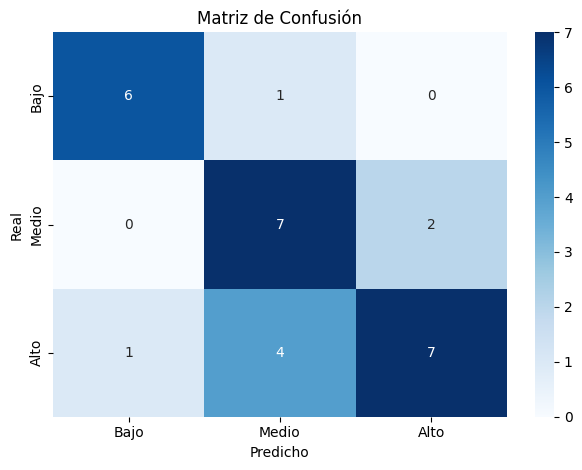

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = grid_svm.predict(X_test)

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, zero_division=0))

etiquetas_ordenadas = ['Bajo', 'Medio', 'Alto']
cm = confusion_matrix(y_test, y_pred, labels=etiquetas_ordenadas)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=etiquetas_ordenadas,
            yticklabels=etiquetas_ordenadas)
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title(f'Matriz de Confusión')
plt.tight_layout()
plt.show()

### 👩‍⚕️Análisis de los resultados

El modelo entrenado fue evaluado en un conjunto de prueba utilizando métricas de clasificación y una matriz de confusión. El accuracy general alcanzado fue del 71%, lo cual refleja un buen desempeño general considerando que se trata de una clasificación en tres rangos de precio: “Bajo”, “Medio” y “Alto”.

La clase “Bajo” fue la más fácil de identificar para el modelo: 6 de 7 casos fueron clasificados correctamente. Esto indica que los patrones asociados a precios bajos —como anticipación alta o duración corta— están bien representados en los datos.

Para la clase “Medio”, el modelo también mostró buen rendimiento (7 aciertos sobre 9), aunque se observaron 2 casos clasificados como “Alto”, lo que sugiere que algunas reservas con características intermedias pueden solaparse con las de precio más alto.

La mayor confusión se dio en la clase “Alto”, donde aunque el modelo acertó en 7 casos, también cometió errores al predecir “Medio” (4 veces) y “Bajo” (1 vez). Esto puede deberse a que no todas las variables que determinan un precio alto están bien capturadas en el dataset actual.

En general, el modelo demuestra ser útil para predecir precios bajos y medios, y ofrece una base sólida para seguir mejorando la discriminación en los casos más altos incorporando nuevas variables o ajustando el balance de clases.

## 💾 Persistencia del modelo seleccionado

Guardamos el mejor modelo para usarlo luego en una nueva notebook.

In [ ]:
mejor_modelo = grid_svm.best_estimator_
joblib.dump(mejor_modelo, 'modelo_svm_precio.joblib')
joblib.dump(X.columns.tolist(), 'columnas_entrenamiento.joblib')

['columnas_entrenamiento.joblib']

## 🛫 Cierre de la entrega: Reflexiones finales

El objetivo de este proyecto fue construir un modelo capaz de predecir el rango de precio de una reserva en ATUA, utilizando datos históricos y características de la reserva. Esta herramienta apunta a mejorar la toma de decisiones comerciales, optimizar la gestión de precios y ofrecer respuestas más ajustadas a la demanda del sistema.

Durante el proceso de modelado se probaron dos enfoques: SVM y LightGBM, ambos entrenados y validados con técnicas de validación cruzada. Finalmente, se eligió SVM como modelo definitivo, ya que alcanzó una mayor accuracy en el conjunto de prueba. En particular, se destacó su capacidad para identificar correctamente reservas de precio “Bajo”, mientras que las clases “Medio” y “Alto” presentaron algo de superposición, lo que era esperable dado que comparten características similares.

Como líneas de mejora, se identificó la posibilidad de incorporar nuevas variables que aporten más contexto, como el día especifico de la semana, eventos especiales (como ofertas) o detalles del perfil del cliente. También se considera relevante abordar el desbalance de clases, ya que esto puede estar afectando la precisión en los rangos menos representados. Aunque el modelo actual ya aporta muchisimo valor para la empresa, hay espacio para seguir optimizándolo y lograr una mejor diferenciación entre segmentos intermedios y altos.

En conclusión, la implementación de este modelo representa un avance concreto para ATUA en la aplicación de herramientas de ciencia de datos al negocio, con resultados prometedores y una base sólida para futuras iteraciones. Funciona como un primer paso para comprender qué variables influyen en las variaciones de precio y permite, a futuro, avanzar hacia la automatización y el desarrollo de un sistema de pricing dinámico más preciso y eficiente.